# Data Analysis 

This notebook contains the data analysis steps to evaluate *Drosophila* data using the MARS tools.

All analysis is done in python3.

## Required modules and tools
#### From conda:
* ipython==7.15.0
* jupyter==4.6.3
* numpy==1.18.5
* pandas==1.0.4
* scipy==1.4.1
* seaborn==0.9.0
* matplotlib==3.2.1

#### From Bioconda
* gimmemotifs==0.14.4
* pybedtools==0.8.1

#### Non-python modules

* meme v5.1.1
* bedtools v2.29.2

## Create the required folders

In [1]:
#Set up the required directories
! [ ! -d Data ] && mkdir Data
! [ ! -d Results ] && mkdir Results
! [ ! -d Figures ] && mkdir Figures

## Import the modules

In [2]:
# Import all the dependacies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from scipy.stats.mstats import winsorize
import scipy.stats
import numpy as np
from math import log
from scipy import stats
#import os moduls
import os
import glob

## Bioconda
import pybedtools

# Make graphs appear in the notebook
#%matplotlib inline

In [5]:
# Set global variables
# path to your genome
dm6 = "../genome/dm6.fa"

## Summarize the motif data

In [4]:
## Read the motifs data file
motif_table = pd.read_csv("../db-tables/dm-motif.tsv", sep = "\t", header = None)

# Get a snippet of the data
#motif_table.head()
# Get info about your data
#motif_table.info()
# Show structure of your data
#motif_table.shape
# Set up column names
motif_table.columns = ["id", "motif_name", "Tf_name", "Collection_db", "Tf_id" ]
# Drop null values as they are uncategorized motifs with no TF class
motif_table = motif_table.dropna()
# Describe the TF id representation
motif_table['Tf_id'].describe()

# Get the counts of each representation
counts = motif_table['Tf_id'].value_counts().rename_axis('Tf_id').to_frame('counts') # Tf_id becomes the index
counts = motif_table['Tf_id'].value_counts().rename_axis('Tf_id').reset_index(name='counts')

# Get TF with over 10 motifs
over10motifs = counts[counts['counts'] >= 5]
over10motifs.shape

(189, 2)

In [5]:
#Get the TF table to extract tf names and join to the over 10 motifs
tf_table = pd.read_csv("../db-tables/Drosophila-TFs.tsv", sep = "\t", header = None)
tf_table.columns = ["Tf_id", "tf_name", "alt_name", "Tf_family" ]
tf_table =tf_table[["Tf_id", "tf_name"]]
# Chenge the int64 type to string in Tf_id
tf_table['Tf_id'] = tf_table.Tf_id.astype('str')

# Merge the file
over10motifs = pd.merge(over10motifs, tf_table, how = 'inner', left_on = ['Tf_id'], right_on = ['Tf_id'])
#Swap columns around
over10motifs = over10motifs.reindex(columns=["Tf_id", "tf_name", "counts"])
#over10motifs

In [2]:
# select a tf to work on
# we will work on bcd
tf = 'lola'

# select the different tf names used on the different databases to a list
## Get the id of the tf name
idtf = over10motifs[over10motifs["tf_name"] == tf]
idtf = idtf ["Tf_id"].values[0]

# Get the motif names in the various data bases
get = motif_table[motif_table["Tf_id"] == idtf]
# Put the names in a list and retain the unique ones
motlist = get["Tf_name"].tolist()
motlist = list(set(motlist))
#motlist

NameError: name 'over10motifs' is not defined

In [7]:
# Get the meme file for the tf
import utils
meme_in = "Data/all_dm_motifs.meme"
out_meme = "Results/" + tf + ".meme"
motlist = motlist
utils.extract_meme_list(meme_in, out_meme, motlist)

## CB-MAR: Tomtom demonstration

This section demonstrates the implementation of CB-MAR

We use bcd to demonstrate how the analysis is carried out.
The _**bcd.meme**_ file which we extracted above is in the **Results** directory.

In [8]:
import run_tomtom
tf = tf
test_meme = "Results/" + tf + ".meme"
results_path = 'Results'

run_tomtom.run_tomtom(tf, test_meme, results_path, figure=True)

### Quick view of the figure

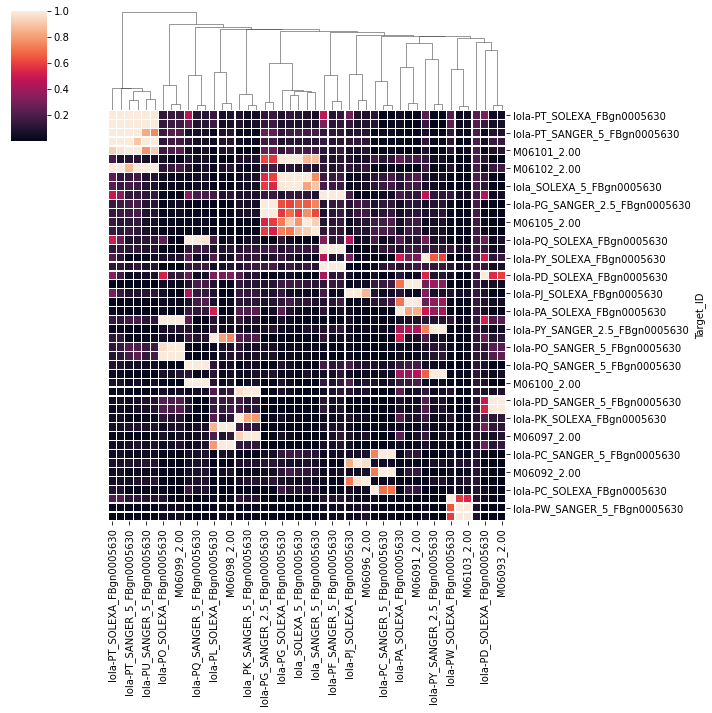

In [9]:
from IPython.display import Image
Image(f"{results_path}/{tf}_tomtom.png")

## FISim analysis

## Scoring and classification motif assessement and ranking

### Assess by score

In [10]:
import Assess_by_score
scoring_fun = "energyscore"
user_motif = "Results/" + tf + ".meme"

In [3]:
import glob
tf = "lola"
chip_list = glob.glob("/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/"+ tf + "/*")
chip_list

['/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF742LVH.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF603JQT.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF275OIZ.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF624NYK.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF048PDV.posneg']

In [12]:
Assess_by_score.run_all(tf, scoring_fun, user_motif, chip_list, results_path)

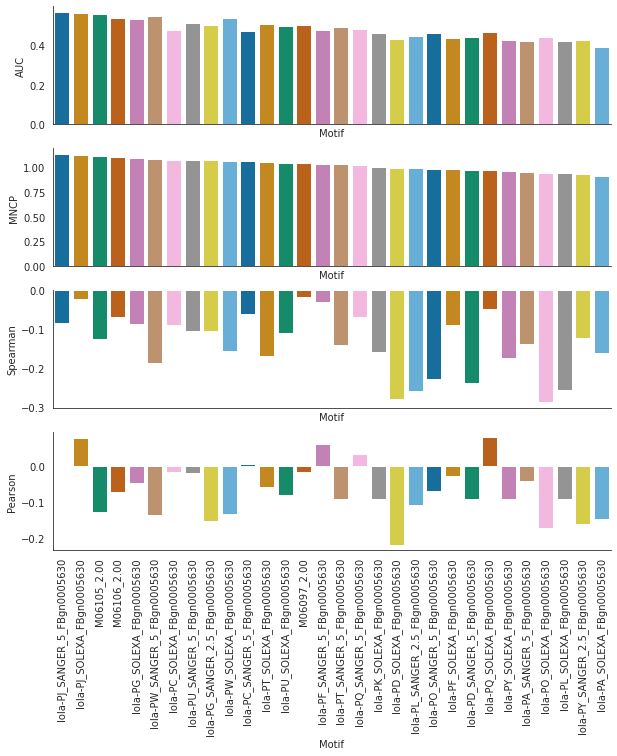

In [13]:
from IPython.display import Image
Image(f"{results_path}/{tf}_assess.png")

## Enrichment-Based Motif assessement and Ranking

In [14]:
import run_centrimo
tf_name = tf
meme_in = 'Results/%s.meme' % tf

In [15]:
run_centrimo.run_centrimo(tf_name,chip_list,meme_in,results_path,figure=True)

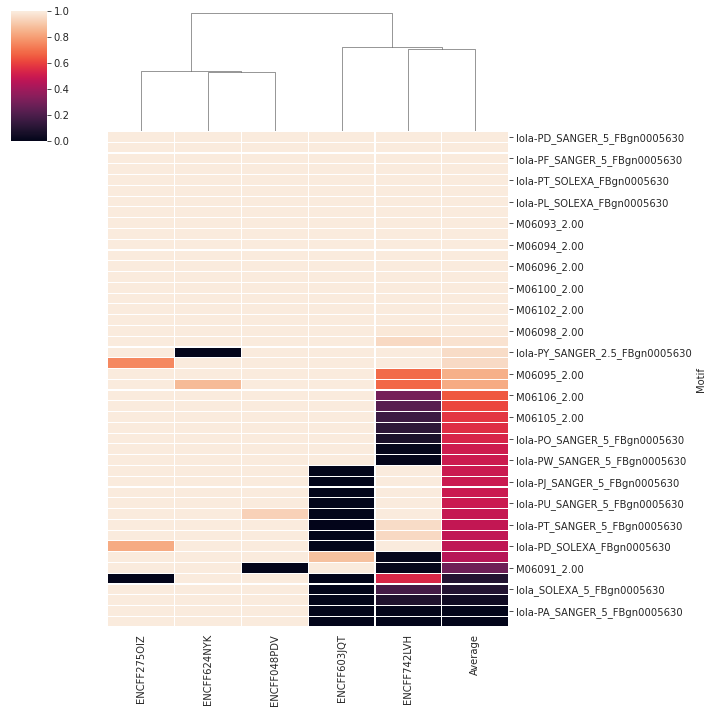

In [16]:
from IPython.display import Image
Image(f"{results_path}/{tf}_centrimo.png")

## SC-MAR: gimme roc

In [6]:
import run_gimme
tf_name = tf
meme_in = 'Results/%s.meme' % tf
#meme_in = 
results_path = "Results"
genome = dm6

In [10]:
run_gimme.run_gimme(tf_name,meme_in,chip_list,results_path,genome,figure=True)

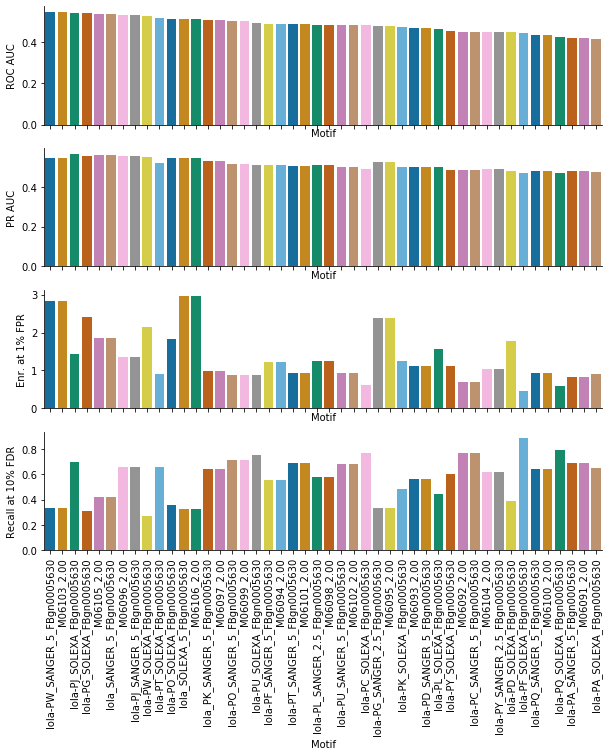

In [11]:
from IPython.display import Image
Image(f"{results_path}/{tf}_gimme.png")